# **Tercer conjunto de tareas a realizar**

## Paquetes necesarios e inicializaciones

Para la realización de las siguientes tareas, se va a utilizar el mismo *enviroment* de Python llamado VC_P1 creado en el [primer conjunto de tareas](../VC_P1/Exercises_P1.ipynb) y modificado después en el [segundo conjunto de tareas](./VC_P2/Exercises_P2.ipynb), la única dependencia adicional que se ha de descargar es la que viene dada por el paquete **scikit-learn** y **seaborn**.

## TAREA 1

En la primera tarea, el reto o tarea consiste en determinar la cantidad de dinero y monedas presentes en la imagen. Una extensión válida sería la presencia de objetos que no sean monedas en la imagen anañizada.

TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 

## TAREA 2

Para la segunda tarea, se proporcionan imágenes de tres clases de objetos recogidos en playas canarias: fragmentos plásticos, *pellets* y alquitrán. Para cada categoría se proporciona una imagen completa y una subimagen de la misma. Las dos primeras categorías se consideran microplásticos cuando miden menos de 5mm, mientras que la tercera es muy habitual encontrarlas en playas canarias. Observar que dado que cada imagen contiene muestras de una única categoría, disponen de un conjunto de datos anotado. La tarea propuesta consiste en primer término, hacer uso de las imágenes proporcionadas, extraer de forma automatizada las partículas e identificar patrones en sus características geométricas y de apariencia que puedan permitir la clasificación de las partículas en dichas imágenes. Las características que determinen se usarán para analizar la imagen de test proporcionada, con presencia de muestras de las tres clases. El resultado obtenido debe mostrarse por medio las métricas mostradas en el cuaderno, incluyendo la matriz de confusión, donde se comparan las anotaciones con las predicciones.

![Confusión](../VC_P3/Resources/MatrizConfu.png)  
*Ejemplo de matriz de confusión*

A la hora de considerar posibles características geométricas, como punto de partida para la extracción de descriptores de las partículas, se proporciona enlace al trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498) en el que se adoptan algunas propiedades geométricas para dicho fin. De forma resumida, las características geométricas utilizadas en dicho trabajo fueron:

- Área en píxeles (A)
- Perímetro en píxeles (P)
- Compacidad (relación del cuadrado del perímetro con el área C=P^2/A)
- Relación del área de la partícula con el área del contenedor que la contiene
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

En relación a la segmentación de las partículas, una probable primera observación es que la aplicación del umbralizado para separarlas del fondo, es delicada. Preprocesamiento como suavizar la imagen de entrada o reducir su tamaño, o aplicar heurísticas basadas en el tamaño mínimo y máximo de los contornos localizados, y la distancia mínima entre ellos, pueden ayudar a filtrar falsas detecciones, pero a pesar de ello, será un desafío obtener una separación perfecta para todas las imágenes con la misma estrategia. Añadir, que la imagen de fragmentos contiene unas 80 partículas, la de *pellets* unas 55 y la de alquitrán unas 54.

Umbral escogido  197.0
Fijo Número de contornos encontrados:  50
Otsu th=197 Número de contornos encontrados:  84
Adaptivo promedio Número de contornos encontrados:  1409
Adaptivo Gaussiano Número de contornos encontrados:  619


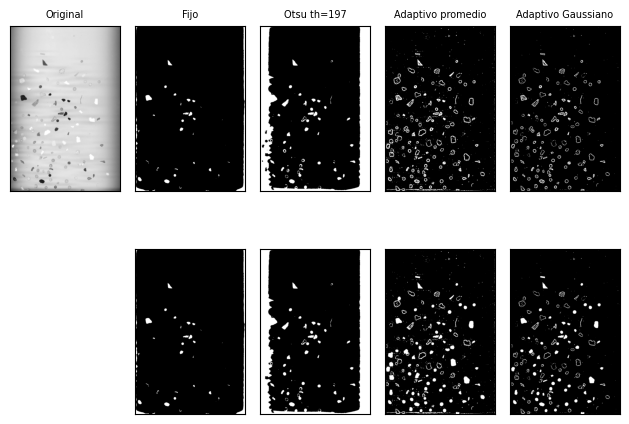

In [21]:
imgorig = cv2.imread('../VC_P3/Resources/Task2/MPs_test.jpg', cv2.IMREAD_GRAYSCALE) 

img = cv2.GaussianBlur(imgorig,(5,5),0)

#Umbralizados
ret,imth1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)

thotsu,imth2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsu)

imth3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)

imth4 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
 
titles = ['Original', 'Fijo','Otsu th='+str(int(thotsu)),
            'Adaptivo promedio', 'Adaptivo Gaussiano']
images = [img, imth1, imth2, 255 - imth3, 255 - imth4]
 
for i in range(5):
    plt.subplot(2,5,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i], fontsize=7)
    plt.xticks([]),plt.yticks([])

    #Obtiene únicamente los contornos externos
    if i > 0:
        res, imth = cv2.threshold(images[i], 120, 255, cv2.THRESH_BINARY)

        contornos, hierarchy= cv2.findContours(imth, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)  
        print(f'{titles[i]} Número de contornos encontrados: ', len(contornos))

        img_cont = np.zeros(img.shape)
        cv2.drawContours(img_cont, contornos, -1, (255, 255, 255), -1)  
        plt.subplot(2, 5, i + 6), plt.imshow(img_cont, 'gray')
        plt.xticks([]),plt.yticks([])

plt.tight_layout()
plt.show()

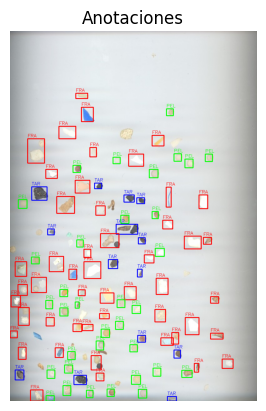

In [22]:
# SOLO PARA EVALUAR
# Imagen y anotaciones
imagen = "../VC_P3/Resources/Task2/MPs_test.jpg"          # Imagen original
csv_file = "../VC_P3/Resources/Task2/MPs_test_bbs.csv"  # CSV con coordenadas y tipología

# Colores de cada clase
colores = {
    "FRA": (0, 0, 255),   # Rojo 
    "PEL": (0, 255, 0),   # Verde
    "TAR": (255, 0, 0)    # Azul
}

# Imagen
img = cv2.imread(imagen)

# Cara csv y dibujar rectángulos
with open(csv_file, newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        etiqueta = row["label"]
        x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
        
        # Color según etiqueta
        color = colores.get(etiqueta, (0, 0, 0))  # negro por defecto si no encuentra
        
        # Dibujar rectángulo
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        
        # Etiqueta 
        cv2.putText(img, etiqueta, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Visualiza resultado
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Anotaciones")
plt.axis('off')
plt.show()


Text(0.5, 1.0, 'Alquitrán')

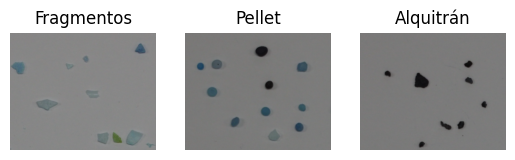

In [25]:
#Cargamos tres subimágenes, por simplicidad, de cada uno de los tres tipos considerados (el alquitrán no es microplástico)
imgF = cv2.imread("../VC_P3/Resources/Task2/FRA.png") 
imgP = cv2.imread("../VC_P3/Resources/Task2/PEL.png") 
imgT = cv2.imread("../VC_P3/Resources/Task2/TAR.png") 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')

In [27]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# --- Cargar imagen ---
img = cv2.imread('../VC_P3/Resources/Task2/MPs_test.jpg', cv2.IMREAD_GRAYSCALE)
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# --- Suavizado y umbral (Otsu recomendado) ---
img_blur = cv2.GaussianBlur(img, (5, 5), 0)
_, img_bin = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# --- Contornos ---
contornos, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

features = []

for cnt in contornos:
    if cv2.contourArea(cnt) < 30:
        continue  # ignorar ruido pequeño

    # --- Medidas básicas ---
    area = cv2.contourArea(cnt)
    perimetro = cv2.arcLength(cnt, True)
    x, y, w, h = cv2.boundingRect(cnt)
    rect_area = w * h
    compacidad = (perimetro ** 2) / (area + 1e-6)
    rel_area = area / rect_area
    rel_wh = w / h if h != 0 else 0

    # --- Elipse (si se puede ajustar) ---
    if len(cnt) >= 5:
        (xc, yc), (MA, ma), angle = cv2.fitEllipse(cnt)
        rel_ejes = MA / ma if ma != 0 else 0
    else:
        rel_ejes = 0

    # --- Centroide ---
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0

    # --- Distancias al contorno ---
    dists = [np.linalg.norm(np.array([cx, cy]) - p[0]) for p in cnt]
    rel_dists = min(dists) / max(dists) if max(dists) != 0 else 0

    features.append({
        "area": area,
        "perimetro": perimetro,
        "compacidad": compacidad,
        "rel_area": rel_area,
        "rel_wh": rel_wh,
        "rel_ejes": rel_ejes,
        "rel_dists": rel_dists,
        "x": x, "y": y, "w": w, "h": h
    })

# --- Convertir a DataFrame ---
df = pd.DataFrame(features)
print(df.head())


    area   perimetro  compacidad  rel_area    rel_wh  rel_ejes  rel_dists  \
0   34.5   48.384776   67.857579  0.154018  1.142857  0.527058   0.110432   
1  854.0  115.396969   15.593045  0.671912  1.322581  0.671162   0.600076   
2  437.5   83.840620   16.066856  0.641496  1.409091  0.653544   0.501721   
3   73.5  129.639609  228.658885  0.145257  0.956522  0.852801   0.594692   
4  211.5   63.213203   18.893187  0.650769  0.520000  0.418028   0.299813   

     x     y   w   h  
0  180  1137  16  14  
1  208  1102  41  31  
2  555  1086  31  22  
3  180  1070  22  23  
4  595  1065  13  25  


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

def scan_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return image, thresh

def redimension_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized

def obtain_geometry(thresh_image):
    contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features_list = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)

        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h if h != 0 else 0
        rect_area = w * h
        extent = area / rect_area if rect_area != 0 else 0

        (_, _), radius = cv2.minEnclosingCircle(cnt)
        
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area != 0 else 0
        
        M = cv2.moments(cnt)
        if M['m00'] != 0:
            cx_centroid = int(M['m10'] / M['m00'])
            cy_centroid = int(M['m01'] / M['m00'])
        else:
            cx_centroid, cy_centroid = 0, 0
        
        edges = cv2.Canny(thresh_image, 100, 200)
        edge_density = np.sum(edges > 0) / edges.size

        features = {
            "area": area,
            "perimeter": perimeter,
            "aspect_ratio": aspect_ratio,
            "extent": extent,
            "min_enclosing_circle_radius": radius,
            "solidity": solidity,
            "centroid": (cx_centroid, cy_centroid),
            "edge_density": edge_density
        }
        features_list.append(features)
    return features_list

